In [2]:
"""Import Statements"""
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_material(materials, name):
    """
    searches materials object for a matching name and returns it
    """
    for material in materials:
        if material.name == name:
            return material

In [4]:
"""Define the geometry of the 'Fuel' Assembly"""

def fuel_assembly(propellent, clad, fuel):
    # build a single element
    # Measurements from Schnitzler et al. 2012
    propellant_channel_diameter = 0.2565
    propellant_channel_inner_cladding_thickness = 0.01
    propellant_channel_pitch = 0.4089
    assembly_cladding_thickness = 0.005
    flat_to_flat = 1.905
    flat_to_flat_fuel = flat_to_flat - assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    fuel_edge_length = 0.5*flat_to_flat_fuel/np.cos(np.deg2rad(30))

    # OpenMC Geometry
    borehole = openmc.ZCylinder(r=propellant_channel_diameter/2)
    borehole_inner_cladding = openmc.ZCylinder(r=propellant_channel_diameter/2
                                               - propellant_channel_inner_cladding_thickness)
    fuel_assembly = openmc.model.HexagonalPrism(
        orientation='x', edge_length=fuel_edge_length)
    fuel_assembly_cladding = openmc.model.HexagonalPrism(
        orientation='x', edge_length=assembly_edge_length)

    # OpenMC Cells and Universes
    propellant_channel_interior = openmc.Cell(
        region=-borehole_inner_cladding, fill=propellent)
    propellant_channel_cladding = openmc.Cell(
        region=-borehole & +borehole_inner_cladding, fill=clad)
    propellant_channel_outer_fuel = openmc.Cell(region=+borehole, fill=fuel)
    propellant_channel = openmc.Universe(cells=(propellant_channel_interior, propellant_channel_cladding,
                                                propellant_channel_outer_fuel))
    fuel_assembly_cell = openmc.Cell(region=-fuel_assembly, fill=fuel)
    fuel_assembly_cladding_cell = openmc.Cell(
        region=+fuel_assembly & -fuel_assembly_cladding, fill=clad)

    outer_lattice_universe = openmc.Universe(cells=[fuel_assembly_cell])

    # OpenMC Fuel Lattice
    fuel_lattice = openmc.HexLattice()
    fuel_lattice.orientation = "x"
    fuel_lattice.outer = outer_lattice_universe
    fuel_lattice.pitch = (propellant_channel_pitch,)
    fuel_lattice.universes = [[propellant_channel] *
                              12, [propellant_channel]*6, [propellant_channel]]
    fuel_lattice.center = (0.0, 0.0)

    # Full Fuel Asembly
    fuel_assembly_lattice_cell = openmc.Cell(
        region=-fuel_assembly, fill=fuel_lattice)
    fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cladding_cell,
                                                    fuel_assembly_lattice_cell])

    return fuel_assembly_universe


In [5]:
"""Define the geometry of the 'Tie Tube' Assembly"""

def tie_tube(hydrogen_inner, hydrogen_outer, inconel, ZrH, ZrC, ZrC_insulator, graphite):
    
    #THIS IS A GUESS BASED ON THE FUEL ELEMENT
    assembly_cladding_thickness = 0.005
    
    inner_hydrogen_outer_radius = 0.20955
    inner_tie_tube_outer_radius = 0.26035
    first_gap_outer_radius = 0.26670
    moderator_outer_radius = 0.58420
    second_gap_outer_radius = 0.67818
    outer_tie_tube_outer_radius = 0.69850
    third_gap_outer_radius = 0.70485
    insulator_outer_radius = 0.80645
    fourth_gap_outer_radius = 0.81280
    flat_to_flat = 1.905
    flat_to_flat_inner = flat_to_flat-2*assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    inner_edge_length = 0.5*flat_to_flat_inner/np.cos(np.deg2rad(30))

    # OpenMC Geometry
    inner_hydrogen = openmc.ZCylinder(r=inner_hydrogen_outer_radius)
    inner_tie_tube = openmc.ZCylinder(r=inner_tie_tube_outer_radius)
    first_gap = openmc.ZCylinder(r=first_gap_outer_radius)
    moderator_tube = openmc.ZCylinder(r=moderator_outer_radius)
    second_gap = openmc.ZCylinder(r=second_gap_outer_radius)
    outer_tie_tube = openmc.ZCylinder(r=outer_tie_tube_outer_radius)
    third_gap = openmc.ZCylinder(r=third_gap_outer_radius)
    insulator = openmc.ZCylinder(r=insulator_outer_radius)
    fourth_gap = openmc.ZCylinder(r=fourth_gap_outer_radius)
    tie_tube_assembly = openmc.model.HexagonalPrism(orientation='x',
                                                    edge_length=inner_edge_length)
    tie_tube_assembly_cladding = openmc.model.HexagonalPrism(orientation='x',
                                                             edge_length=assembly_edge_length)

    # OpenMC Cells and Universes
    inner_hydrogen_cell = openmc.Cell(region=-inner_hydrogen, fill=hydrogen_inner)
    inner_tie_tube_cell = openmc.Cell(
        region=+inner_hydrogen & - inner_tie_tube, fill=inconel)
    first_gap_cell = openmc.Cell(region=+inner_tie_tube & -first_gap, fill=hydrogen_outer)
    moderator_tube_cell = openmc.Cell(region=+first_gap & -moderator_tube,fill=ZrH)
    outer_hydrogen_cell = openmc.Cell(region=+moderator_tube & -second_gap, fill=hydrogen_outer)
    outer_tie_tube_cell = openmc.Cell(region=+second_gap & -outer_tie_tube, fill=inconel)
    third_gap_cell = openmc.Cell(region=+outer_tie_tube & -third_gap, fill=hydrogen_outer)
    insulator_cell = openmc.Cell(region=+outer_tie_tube & -insulator,fill = ZrC_insulator)
    fourth_gap_cell = openmc.Cell(region=+insulator & -fourth_gap, fill=hydrogen_outer)
    tie_tube_assembly_cell = openmc.Cell(region=-tie_tube_assembly & +fourth_gap, fill=graphite)
    tie_tube_assembly_cladding_cell = openmc.Cell(
        region=+tie_tube_assembly & -tie_tube_assembly_cladding, fill=ZrC)

    # Full Tie Tube Assembly
    tie_tube_assembly_universe = openmc.Universe(cells=[inner_hydrogen_cell, inner_tie_tube_cell, first_gap_cell,
                                                        moderator_tube_cell, outer_hydrogen_cell, outer_tie_tube_cell,
                                                        third_gap_cell, insulator_cell, fourth_gap_cell,
                                                        tie_tube_assembly_cell, tie_tube_assembly_cladding_cell])
    
    return tie_tube_assembly_universe

In [6]:
def beryllium_assembly(Be, ZrC):
    
    # Measurements from Schnitzler et al. 2012
    assembly_cladding_thickness = 0.005
    flat_to_flat = 1.905
    flat_to_flat_inner = flat_to_flat-2*assembly_cladding_thickness
    assembly_edge_length = 0.5*flat_to_flat/np.cos(np.deg2rad(30))
    inner_edge_length = 0.5*flat_to_flat_inner/np.cos(np.deg2rad(30))
    
    # OpenMC Geometry:
    beryllium_assembly = openmc.model.HexagonalPrism(orientation='x',
                                                    edge_length=inner_edge_length)
    beryllium_assembly_cladding = openmc.model.HexagonalPrism(orientation='x',
                                                             edge_length=assembly_edge_length)
    
    
    # Cells and Universes:
    beryllium_assembly_cell = openmc.Cell(region=-beryllium_assembly, fill=Be)
    beryllium_assembly_cladding_cell = openmc.Cell(
        region=+beryllium_assembly & -beryllium_assembly_cladding, fill=ZrC)
    
    beryllium_assembly_universe = openmc.Universe(cells=[beryllium_assembly_cell, beryllium_assembly_cladding_cell])
    
    return beryllium_assembly_universe

In [7]:
def core_lattice_SNRE(tie_tube_universe, fuel_assembly_universe, beryllium_universe):
    
    # Measurements from Schnitzler et al. 2012
    assembly_pitch = 1.905
    
    
    # Makes things easier to type:
    TT = tie_tube_universe
    FA = fuel_assembly_universe
    BE = beryllium_universe
    
    core_lattice = openmc.HexLattice()
    core_lattice.orientation = "y"
    core_lattice.pitch = (assembly_pitch,)
    core_lattice.universes = [[BE, BE, BE, BE, BE, BE, BE, FA, FA, FA, FA, BE, BE, BE, BE, BE, BE]*6,
                              [BE, BE, BE, FA, FA, FA, FA, FA, TT, FA, FA, FA, FA, FA, BE, BE]*6,
                              [BE, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA, FA, TT, FA]*6,
                              [TT, FA, FA, TT, FA, FA]*6,
                              [FA, TT, FA, FA, TT]*6,
                              [FA, FA, TT, FA]*6,
                              [TT, FA, FA]*6,
                              [FA, TT]*6,
                              [FA]*6,
                              [TT]]
    core_lattice.center=(0.0,0.0)
    core_lattice_cell = openmc.Cell(fill=core_lattice)
    core_lattice_universe = openmc.Universe(cells=[core_lattice_cell])
    
    return core_lattice_universe

In [13]:
def reflector(Core, Gap, SS, Be_Barrel):
    
    #Measurements from Schnitzler et al. 2007
    inner_gap_inner_radius = 29.5275
    inner_gap_outer_radius = 29.8450
    stainless_steel_outer_radius = 30.1625
    middle_gap_outer_radius = 30.48
    be_barrel_outer_radius = 33.3375
    outer_gap_outer_radius = 33.6550
    
    # OpenMC Geometry:
    inner_gap_inner = openmc.ZCylinder(r=inner_gap_inner_radius)
    inner_gap_outer = openmc.ZCylinder(r=inner_gap_outer_radius)
    wrapper = openmc.ZCylinder(r=stainless_steel_outer_radius)
    middle_gap = openmc.ZCylinder(r=middle_gap_outer_radius)
    be_barrel = openmc.ZCylinder(r=be_barrel_outer_radius)
    outer_gap = openmc.ZCylinder(r=outer_gap_outer_radius)
    
    # OpenMC Cells and Universes:
    core_cell = openmc.Cell(region=-inner_gap_inner, fill=Core)
    inner_gap_cell = openmc.Cell(region = -inner_gap_outer & + inner_gap_inner, fill=Gap)
    stainless_steel_wrapper_cell = openmc.Cell (region = +inner_gap_outer & -wrapper, fill=SS)
    middle_gap_cell = openmc.Cell(region = +wrapper & -middle_gap, fill=Gap)
    be_barrel_cell = openmc.Cell(region = +middle_gap & -be_barrel, fill=Be_Barrel)
    outer_gap_cell = openmc.Cell(region = +be_barrel & -outer_gap, fill=Gap)
    
    reflector_universe = openmc.Universe(cells=[core_cell, inner_gap_cell,
                                                stainless_steel_wrapper_cell,
                                                middle_gap_cell, be_barrel_cell,
                                                outer_gap_cell])
    
    return reflector_universe
    

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=9.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=6.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=5.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=10.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=8.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(

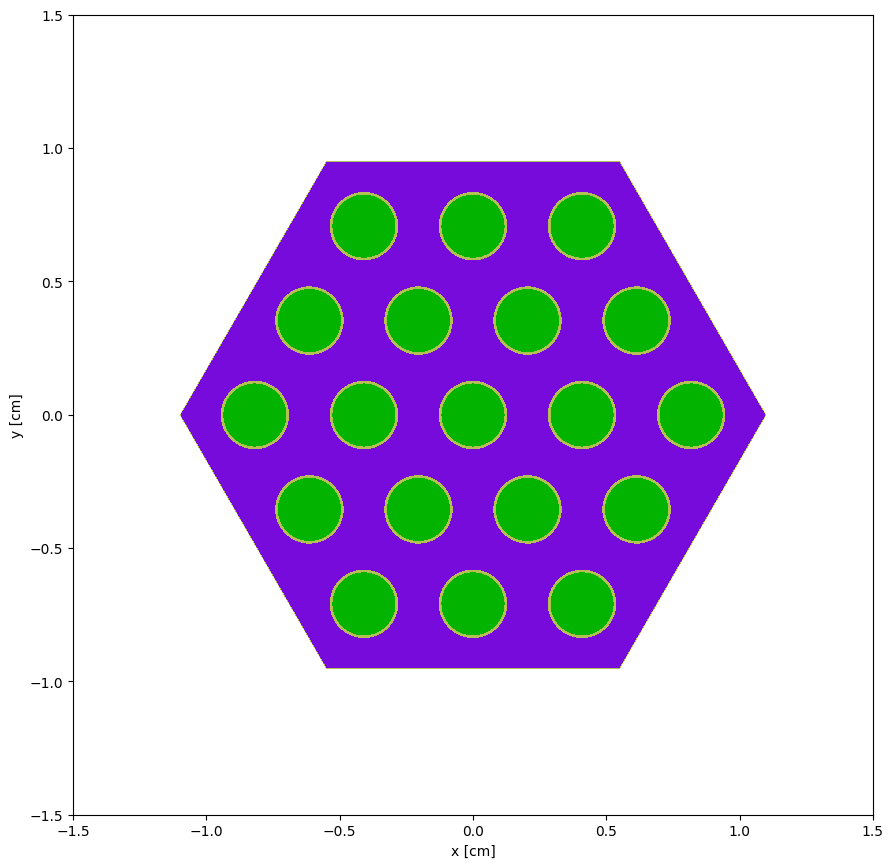

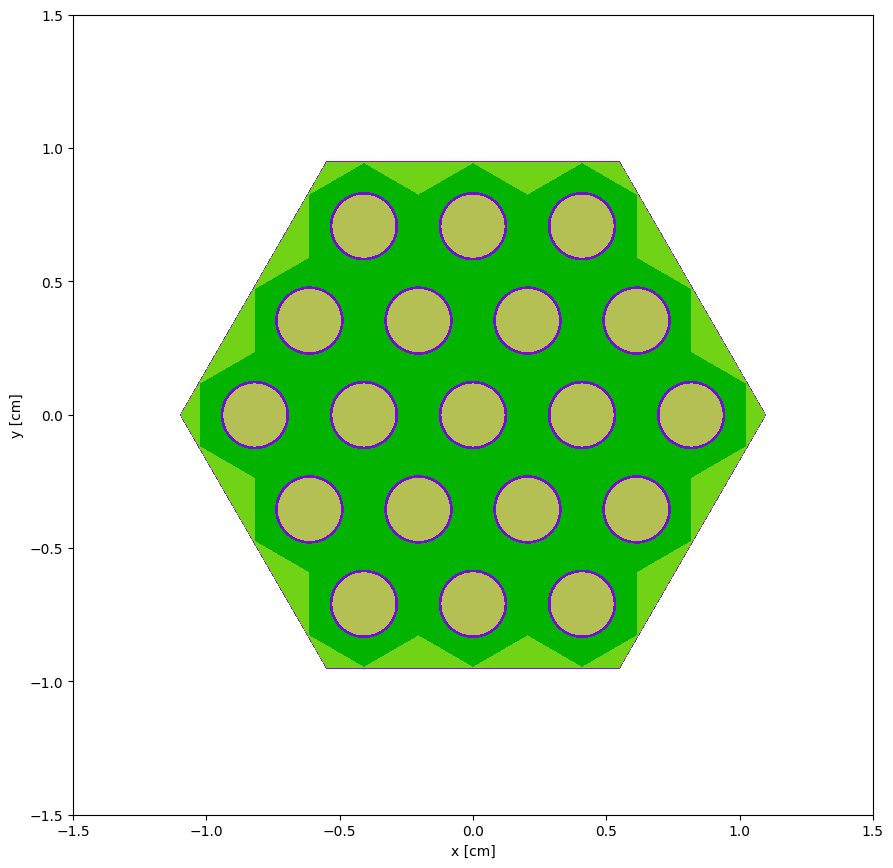

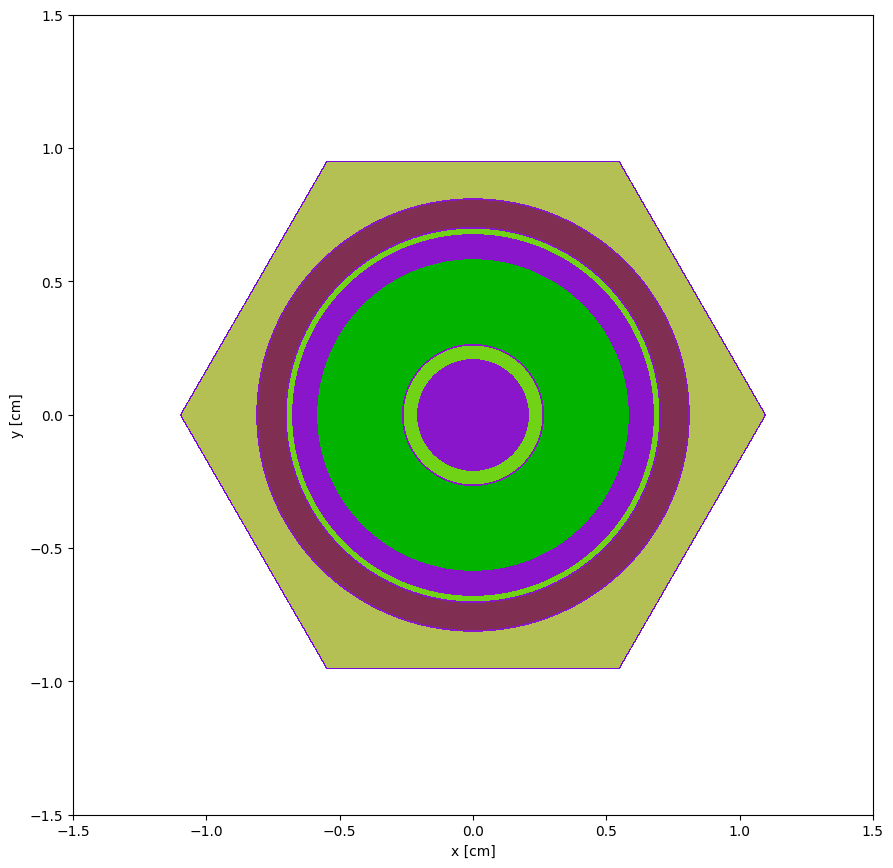

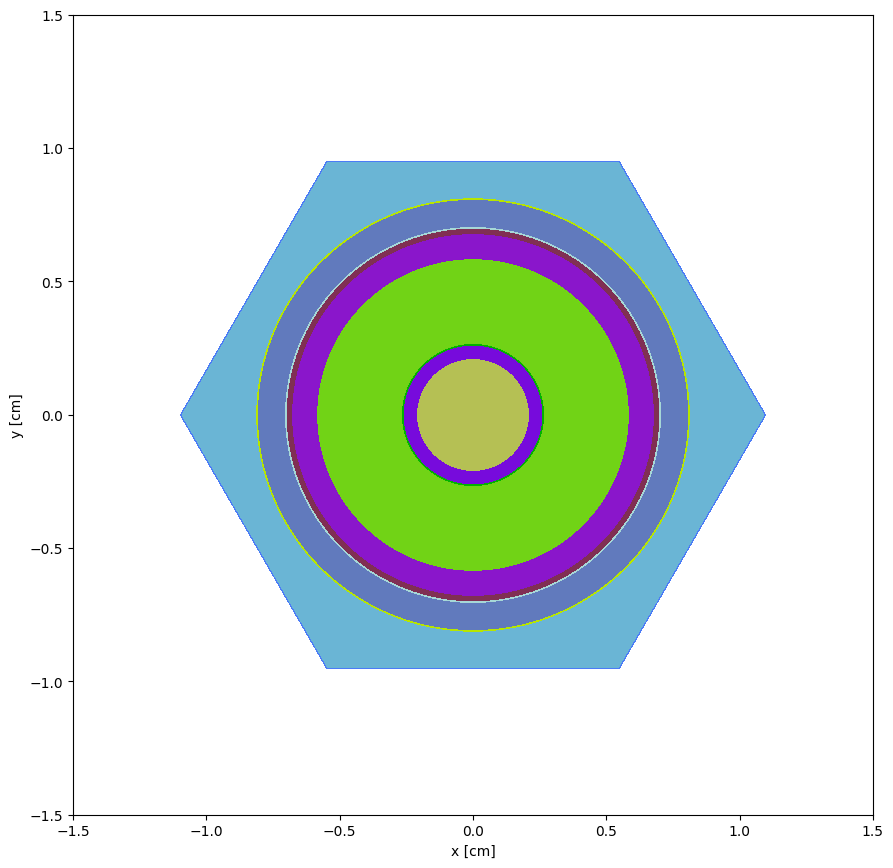

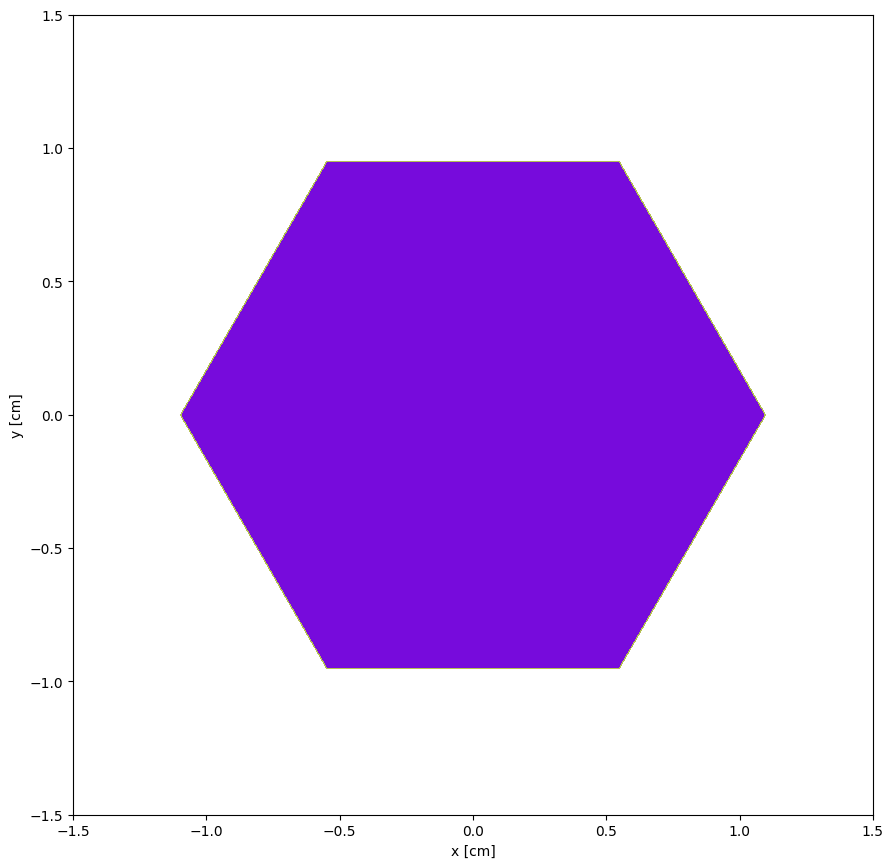

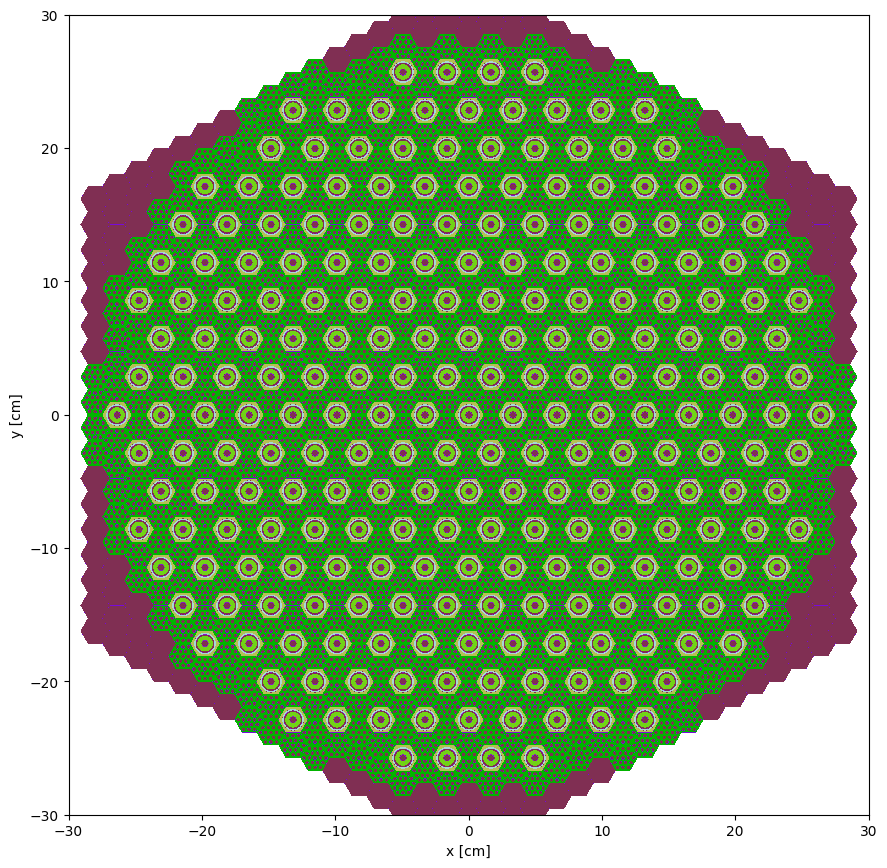

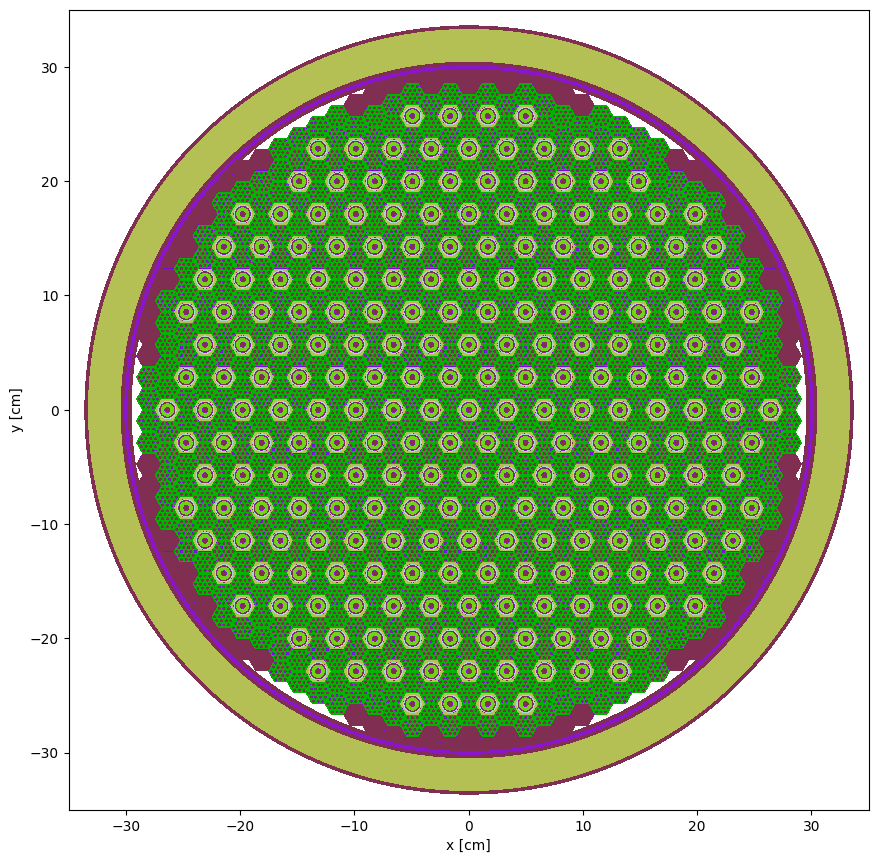

In [14]:
"""Main Standin"""

materials = openmc.Materials.from_xml('materials.xml')

hydrogen = get_material(materials, "Hydrogen STP")
ZrC = get_material(materials, "zirconium_carbide")
graphite_fuel = get_material(materials, "graphite_fuel_70U_15C")
ZrH = get_material(materials, 'zirconium_hydride_II')
inconel = get_material(materials, "inconel-718")
ZrC_insulator = get_material(materials,'zirconium_carbide_insulator')
graphite = get_material(materials, 'graphite_carbon')

fuel_assembly_geom = openmc.Geometry(fuel_assembly(hydrogen, ZrC, graphite_fuel))
fuel_assembly_geom.plot(pixels=(800, 800), width=(3, 3), color_by='material')
plt.show() #plt.savefig('fuel_element_by_material.png')

fuel_assembly_geom.plot(pixels=(800, 800), width=(3, 3), color_by='cell')
plt.show()#plt.savefig('fuel_element_by_cell.png')

tie_tube_geom = openmc.Geometry(tie_tube(hydrogen,hydrogen,inconel,ZrH,ZrC,ZrC_insulator,graphite))
tie_tube_geom.plot(pixels=(800, 800), width=(3, 3), color_by='material')
plt.show() #plt.savefig('tie_tube_element_by_material.png')

tie_tube_geom.plot(pixels=(800, 800), width=(3, 3), color_by='cell')
plt.show()#plt.savefig('tie_tube_element_by_cell.png')


#I FILL THE Be CELL WITH H BECAUSE I CAN'T MAKE MATERIALS TO ADD Be (!!!)
beryllium_assembly_geom = openmc.Geometry(beryllium_assembly(hydrogen, ZrC))
beryllium_assembly_geom.plot(pixels=(800, 800), width=(3, 3), color_by='material')
plt.show()

FA = fuel_assembly(hydrogen, ZrC, graphite_fuel)
TT = tie_tube(hydrogen,hydrogen,inconel,ZrH,ZrC,ZrC_insulator,graphite)
BE = beryllium_assembly(hydrogen, ZrC)

core_lattice_SNRE_geom = openmc.Geometry(core_lattice_SNRE(TT, FA, BE))
core_lattice_SNRE_geom.plot(pixels=(800, 800), width=(60, 60), color_by='material')
plt.show()


core = core_lattice_SNRE(TT,FA, BE)


# Filled with random materials because I can't make mats... (!!)
reflector_geom = openmc.Geometry(reflector(core, hydrogen, inconel, graphite))
reflector_geom.plot(pixels=(800, 800), width=(70, 70), color_by='material')
plt.show()